Для датасету https://archive.ics.uci.edu/ml/datasets/Abalone побудувати модель класифікації

*   первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, duplicated, Nan) (+)
*   фича інжиніринг (побудувати 1-2 нові фічі) (+)
*   Убрать кореляцію в фічах (+)
*   поділ датасету на train, validate, test (+ random_state) (+)
*   GridSearchCV (+)
*   Scaling (+)
*   NearestCentroid() (+)
*   тренування базової моделі із дефолтними гіперпараметрами (кожну модель) (+)
*   підбір гіперпараметрів (кожну модель) (+)
*   Таргет - вік Rings (кількість кілець) (+)
*   Додатково: таргет - стать Sex (infant, male, female)
*   побудувати модель різними способами ( ...) (+)
*   Metrics: classification_report, ROC-AUC, precision_recall_curve ...
*   оцінка результатів (порівняння всіх на тестовій частині, описати яка краще) (+)


### Import Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.container import BarContainer
from pandas.core.arrays.sparse.array import NaT
from pandas.core.groupby import DataFrameGroupBy
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, precision_recall_curve,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from imblearn.over_sampling import ADASYN, BorderlineSMOTE


### Main Init

In [2]:
RANDOM_STATE: int = 1729


def load_model(model_name):
    with open(model_name, "rb") as file:
      return pickle.load(file)


def mount_google_drive() -> bool | None:
    """
    Function to mount Google Drive.
    :return: True if mounting is successful, None otherwise.
    """
    try:
        from google.colab.drive import mount

        mount(mountpoint="/content/drive")
        return True

    except Exception as error:
        print(f"Error while mounting Google Drive: {error}")
        raise


def get_google_drive_dataset_path() -> tuple:
    """
    Function to retrieve the path of the raw dataset from Google Drive.
    :return: Path of raw dataset as a string.
    """
    return ("/content/drive/MyDrive/Hillel/Machine_Learning_Course/HW6/abalone/abalone.data",)


def get_data_frame(dataset_path: str) -> tuple[pd.DataFrame] | None:
    """
    Function to convert the dataset into a pd.DataFrame.
    :param dataset_path: Path or URL of the dataset.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    try:
        return pd.read_csv(filepath_or_buffer=dataset_path, sep=",", header=None)

    except Exception as error:
        print(f"Error while converting dataset to NumPy array: {error}")
        raise


def main() -> tuple[pd.DataFrame] | None:
    """
    Main function to start the app.
    :return: pd.DataFrame containing the dataset, or None if errors occur.
    """
    if mount_google_drive():
        import os

        datasets_paths: tuple = get_google_drive_dataset_path()
        if all(map(os.path.exists, datasets_paths)):
            data_frames: tuple = tuple(get_data_frame(dataset_path=path) for path in datasets_paths)

            return data_frames

        else:
            print("Dataset path doesn't exists.")
            raise FileNotFoundError


if __name__ == "__main__":
    raw_data_frames: tuple | None = main()
    if raw_data_frames:
      abalone_dataframe: pd.DataFrame = raw_data_frames[0]


Mounted at /content/drive


### Data preparing

In [3]:
## Додаємо хедери
headers: tuple = ("Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings")
abalone_dataframe.columns = headers

In [4]:
## Замінюємо значення в колонці "Sex": "M"=0, "F"=1, "I"=2
abalone_dataframe["Sex"] = abalone_dataframe["Sex"].replace({"M": 0, "F": 1, "I": 2})

In [5]:
## Перевіряємо на дублікати
abalone_dataframe.duplicated().sum()

0

In [6]:
## Перевіряємо розподіл классів
abalone_dataframe["Sex"].value_counts()

0    1528
2    1342
1    1307
Name: Sex, dtype: int64

In [7]:
## Міняємо типи даних для пришвидшення та економії памʼяті
abalone_dataframe[["Sex", "Rings"]]: pd.DataFrame = abalone_dataframe[["Sex", "Rings"]].astype(np.byte)

In [8]:
## Генеруємо статистику
abalone_dataframe.describe(include="all", percentiles=[.25, .5, .75])

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.955470,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.827815,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [9]:
## NAN відсутні
abalone_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   int8   
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int8   
dtypes: float64(7), int8(2)
memory usage: 236.7 KB


In [10]:
sex_abalone_dataframe: pd.DataFrame = abalone_dataframe.copy()

### Feature Engineering

<Axes: >

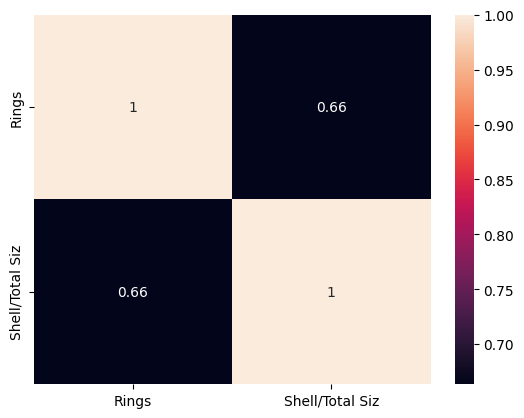

In [11]:
main_features: tuple = ("Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings")

abalone_dataframe["Total Size"] = abalone_dataframe["Length"] + abalone_dataframe["Diameter"] + abalone_dataframe["Height"]
abalone_dataframe["Shell/Total Siz"] = abalone_dataframe["Shell weight"] / abalone_dataframe["Total Size"]
abalone_dataframe = abalone_dataframe.drop(["Sex", "Length", "Diameter", "Height", "Whole weight", "Shell weight", "Shucked weight", "Viscera weight", "Total Size"], axis=1)
## Heatmap
abalone_corr_matrix = abalone_dataframe.corr()
sns.heatmap(data=abalone_corr_matrix, annot=True)
## зробили одну фічу з всіх, яка найбільше корелює до таргету

### Балансування классів

In [12]:
# Дублюємо ті строки, де недостатньо записів "Rings" кожного віку
counts = abalone_dataframe["Rings"].value_counts()
single_counts = counts[counts < 7].index

df_duplicate: pd.DataFrame = abalone_dataframe[abalone_dataframe["Rings"].isin(single_counts)].copy()
df_duplicate: pd.DataFrame = pd.concat([df_duplicate] * 4, axis=0, ignore_index=True)
abalone_dataframe: pd.DataFrame = pd.concat([abalone_dataframe, df_duplicate], ignore_index=True)
# abalone_dataframe["Rings"].value_counts()

In [13]:
## балансуємо класи через Oversampling
balancer = BorderlineSMOTE(random_state=123, k_neighbors=1)
X_resampled, y_resampled = balancer.fit_resample(X=abalone_dataframe.drop("Rings", axis=1), y=abalone_dataframe["Rings"])

# y_resampled.value_counts()

### Splitting Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=334)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=334)

# X_train.info()
# X_validate.info()
# X_test.info()

### Scaling

In [15]:
scaler: StandardScaler = StandardScaler().fit(X=X_train)

X_train_scaled: np.ndarray = scaler.transform(X=X_train)
X_validate_scaled: np.ndarray = scaler.transform(X=X_validate)
X_test_scaled: np.ndarray = scaler.transform(X=X_test)

### GridSearch

In [16]:
def value_results(model, name: str, model_predict, y_test):
    print("'" * 50)

    print(name)

    ## Metrics
    accuracy = accuracy_score(y_true=y_test, y_pred=model_predict)
    precision = precision_score(y_true=y_test, y_pred=model_predict, average="micro")
    recall = recall_score(y_true=y_test, y_pred=model_predict, average="micro")
    f1 = f1_score(y_true=y_test, y_pred=model_predict, average="micro")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    print("'" * 50)

In [35]:
## KNeighborsClassifier() з підбіром параметрів через GridSearchCV
model_kn_grid = KNeighborsClassifier()

param_grid_kn = {
    "n_neighbors": list(range(1,31)),

    # "weights": ["uniform", "distance"], # best - uniform
    "weights": ["uniform",],

    # "metric": ["euclidean", "manhattan", "cityblock", "l1", "l2", "cosine", "haversine", "nan_euclidean"], # best - euclidean
    "metric": ["euclidean",],

    # "algorithm": ["auto", "ball_tree", "kd_tree", "brute"], # best - ball_tree
    "algorithm": ["ball_tree",],

    # "leaf_size": list(range(20,41)), # best 25
    "leaf_size": [25,],
}

grid_search_kn = GridSearchCV(model_kn_grid, param_grid_kn)
grid_search_kn.fit(X_train_scaled, y_train)

print("best_params: ", grid_search_kn.best_params_)
print("best_score: ", grid_search_kn.best_score_)

y_pred_kn_grid = grid_search_kn.predict(X_validate_scaled)

print(classification_report(y_validate, y_pred_kn_grid))

value_results(model=grid_search_kn, name="KNeighborsClassifier+GridSearch", model_predict=y_pred_kn_grid, y_test=y_validate)

best_params:  {'algorithm': 'ball_tree', 'leaf_size': 25, 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
best_score:  0.7229311512896366
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        97
           3       0.80      0.93      0.86        98
           4       0.88      0.85      0.87        95
           5       0.79      0.77      0.78        92
           6       0.58      0.67      0.62        84
           7       0.53      0.56      0.55        98
           8       0.24      0.29      0.26        98
           9       0.15      0.15      0.15        81
          10       0.15      0.11      0.13        80
          11       0.41      0.25      0.31       104
          12       0.54      0.48      0.51        90
          13       0.52      0.58      0.55        95
          14       0.76      0.74      0.75       106
          15       0.62      0.62   

In [18]:
## KNeighborsClassifier() with defaults
kn_model = KNeighborsClassifier()
kn_model.fit(X_train_scaled, y_train)

y_pred_kn = kn_model.predict(X_validate_scaled)

print(classification_report(y_validate, y_pred_kn))

value_results(model=kn_model, name="KNeighborsClassifier+Clean", model_predict=y_pred_kn, y_test=y_validate)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        95
           2       1.00      1.00      1.00        97
           3       0.80      0.93      0.86        98
           4       0.88      0.85      0.87        95
           5       0.79      0.77      0.78        92
           6       0.58      0.67      0.62        84
           7       0.53      0.56      0.55        98
           8       0.25      0.29      0.26        98
           9       0.15      0.15      0.15        81
          10       0.15      0.11      0.13        80
          11       0.43      0.26      0.32       104
          12       0.54      0.48      0.51        90
          13       0.52      0.58      0.55        95
          14       0.76      0.74      0.75       106
          15       0.62      0.62      0.62        93
          16       0.77      0.89      0.82        84
          17       0.66      0.68      0.67        95
          18       0.77    

In [19]:
## NearestCentroid() з підбіром параметрів через GridSearchCV
model_centr_grid = NearestCentroid()

param_grid_centr = {
    # "metric": ["euclidean", "manhattan", "cityblock", "l1", "l2", "cosine", "haversine", "nan_euclidean", "precomputed"], # best - manhattan
    "metric": ["manhattan",],
    # "shrink_threshold": []
}

grid_search_centr = GridSearchCV(model_centr_grid, param_grid_centr)
grid_search_centr.fit(X_train_scaled, y_train)

print("best_params: ", grid_search_centr.best_params_)
print("best_score: ", grid_search_centr.best_score_)

y_pred_grid_centr = grid_search_centr.predict(X_validate_scaled)

print(classification_report(y_validate, y_pred_grid_centr))

value_results(model=grid_search_centr, name="NearestCentroid+GridSearch", model_predict=y_pred_grid_centr, y_test=y_validate)

best_params:  {'metric': 'manhattan'}
best_score:  0.4040698549580002
              precision    recall  f1-score   support

           1       0.84      1.00      0.91        95
           2       0.66      1.00      0.79        97
           3       0.32      0.10      0.16        98
           4       0.40      0.46      0.43        95
           5       0.57      0.52      0.55        92
           6       0.40      0.44      0.42        84
           7       0.44      0.44      0.44        98
           8       0.22      0.33      0.26        98
           9       0.09      0.12      0.10        81
          10       0.06      0.14      0.08        80
          11       0.13      0.09      0.10       104
          12       0.02      0.01      0.01        90
          13       0.04      0.02      0.03        95
          14       0.15      0.04      0.06       106
          15       0.18      0.11      0.13        93
          16       0.08      0.07      0.08        84
          1

In [20]:
## NearestCentroid() with defaults
centr_model = NearestCentroid()
centr_model.fit(X_train_scaled, y_train)

y_pred_centr = centr_model.predict(X_validate_scaled)

print(classification_report(y_validate, y_pred_centr))

value_results(model=centr_model, name="NearestCentroid+Clean", model_predict=y_pred_centr, y_test=y_validate)

              precision    recall  f1-score   support

           1       0.84      1.00      0.91        95
           2       0.66      1.00      0.79        97
           3       0.57      0.29      0.38        98
           4       0.48      0.46      0.47        95
           5       0.58      0.58      0.58        92
           6       0.43      0.45      0.44        84
           7       0.42      0.44      0.43        98
           8       0.17      0.29      0.21        98
           9       0.07      0.07      0.07        81
          10       0.06      0.14      0.08        80
          11       0.10      0.12      0.11       104
          12       0.03      0.02      0.03        90
          13       0.09      0.03      0.05        95
          14       0.00      0.00      0.00       106
          15       0.25      0.04      0.07        93
          16       0.14      0.07      0.09        84
          17       0.22      0.08      0.12        95
          18       0.63    

### Value result

In [36]:
value_results(model=grid_search_kn, name="KNeighborsClassifier+GridSearch", model_predict=grid_search_kn.predict(X_test_scaled), y_test=y_test)

value_results(model=kn_model, name="KNeighborsClassifier+Clean", model_predict=kn_model.predict(X_test_scaled), y_test=y_test)

value_results(model=grid_search_centr, name="NearestCentroid+GridSearch", model_predict=grid_search_centr.predict(X_test_scaled), y_test=y_test)

value_results(model=centr_model, name="NearestCentroid+Clean", model_predict=centr_model.predict(X_test_scaled), y_test=y_test)

## Тут бачимо, що KNeighborsClassifier з автоматично підібраними GridSearchCV гіперпараметрами віддає найкращий предікт, з дуже маленьким відривом
## від чистої KNeighborsClassifier з дефолтними параметрами.
## Модель з точністю приблизно 73 відсотки правильно класифікує вік.

''''''''''''''''''''''''''''''''''''''''''''''''''
KNeighborsClassifier+GridSearch
Accuracy: 0.7378335949764521
Precision: 0.7378335949764521
Recall: 0.7378335949764521
F1 Score: 0.737833594976452
''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''
KNeighborsClassifier+Clean
Accuracy: 0.7370486656200942
Precision: 0.7370486656200942
Recall: 0.7370486656200942
F1 Score: 0.7370486656200942
''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''
NearestCentroid+GridSearch
Accuracy: 0.40345368916797486
Precision: 0.40345368916797486
Recall: 0.40345368916797486
F1 Score: 0.40345368916797486
''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''
NearestCentroid+Clean
Accuracy: 0.33516483516483514
Precision: 0.33516483516483514
Recall: 0.33516483516483514
F1 Score: 0.33516483516483514
''''''''''''''''''''''''''''''''''''''''''''''''''


### Abalone Sex

<Axes: >

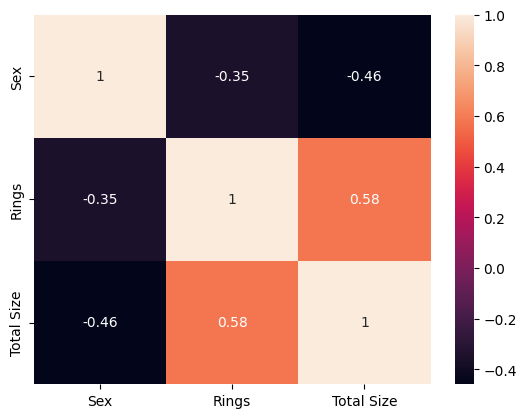

In [22]:
main_features: tuple = ("Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings")

sex_abalone_dataframe["Total Size"] = sex_abalone_dataframe["Length"] + sex_abalone_dataframe["Diameter"] + sex_abalone_dataframe["Height"]
sex_abalone_dataframe["Shell/Total Siz"] = sex_abalone_dataframe["Shell weight"] / sex_abalone_dataframe["Total Size"]

sex_abalone_dataframe = sex_abalone_dataframe.drop(["Length", "Diameter", "Height", "Shell weight", "Shucked weight", "Viscera weight", "Whole weight", "Shell/Total Siz"], axis=1)
## Heatmap
abalone_sex_corr_matrix = sex_abalone_dataframe.corr()
sns.heatmap(data=abalone_sex_corr_matrix, annot=True)
## зробили одну фічу з всіх, яка найбільше корелює до таргету

In [23]:
X_sex = sex_abalone_dataframe.drop("Sex", axis=1)
y_sex = sex_abalone_dataframe["Sex"]

X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(X_sex, y_sex, test_size=0.2, random_state=334)
X_sex_validate, X_sex_test, y_sex_validate, y_sex_test = train_test_split(X_sex_test, y_sex_test, test_size=0.33, random_state=334)

# X_sex_train.info()
# X_sex_validate.info()
# X_sex_test.info()

In [24]:
scaler_sex: StandardScaler = StandardScaler().fit(X=X_sex_train)

X_sex_train_scaled: np.ndarray = scaler_sex.transform(X=X_sex_train)
X_sex_validate_scaled: np.ndarray = scaler_sex.transform(X=X_sex_validate)
X_sex_test_scaled: np.ndarray = scaler_sex.transform(X=X_sex_test)

In [25]:
## KNeighborsClassifier() з підбіром параметрів через GridSearchCV
model_kn_grid_sex = KNeighborsClassifier()

param_grid_kn_sex = {
    "n_neighbors": list(range(1,30)),

    # "weights": ["uniform", "distance"], # best - uniform
    "weights": ["uniform",],

    # "metric": ["euclidean", "manhattan", "cityblock", "l1", "l2", "cosine", "haversine", "nan_euclidean"], # best - manhattan
    "metric": ["manhattan"],

    # "algorithm": ["auto", "ball_tree", "kd_tree", "brute"], # best - brute
    "algorithm": ["brute",],
}

grid_search_kn_sex = GridSearchCV(model_kn_grid_sex, param_grid_kn_sex)
grid_search_kn_sex.fit(X_sex_train_scaled, y_sex_train)

print("best_params: ", grid_search_kn_sex.best_params_)
print("best_score: ", grid_search_kn_sex.best_score_)

y_pred_kn_grid_sex = grid_search_kn_sex.predict(X_sex_validate_scaled)

print(classification_report(y_sex_validate, y_pred_kn_grid_sex))

value_results(model=grid_search_kn_sex, name="KNeighborsClassifier+GridSearch_SEX", model_predict=y_pred_kn_grid_sex, y_test=y_sex_validate)

best_params:  {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}
best_score:  0.5297816922209393
              precision    recall  f1-score   support

           0       0.42      0.47      0.45       196
           1       0.45      0.38      0.41       170
           2       0.74      0.75      0.75       194

    accuracy                           0.54       560
   macro avg       0.54      0.54      0.54       560
weighted avg       0.54      0.54      0.54       560

''''''''''''''''''''''''''''''''''''''''''''''''''
KNeighborsClassifier+GridSearch_SEX
Accuracy: 0.5428571428571428
Precision: 0.5428571428571428
Recall: 0.5428571428571428
F1 Score: 0.5428571428571428
''''''''''''''''''''''''''''''''''''''''''''''''''


In [26]:
## KNeighborsClassifier() with defaults
kn_sex_model = KNeighborsClassifier()
kn_sex_model.fit(X_sex_train_scaled, y_sex_train)

y_sex_pred_kn = kn_sex_model.predict(X_sex_validate_scaled)

print(classification_report(y_sex_validate, y_sex_pred_kn))

value_results(model=kn_sex_model, name="KNeighborsClassifier+Clean_SEX", model_predict=y_sex_pred_kn, y_test=y_sex_validate)

              precision    recall  f1-score   support

           0       0.40      0.47      0.43       196
           1       0.41      0.37      0.39       170
           2       0.74      0.66      0.70       194

    accuracy                           0.51       560
   macro avg       0.51      0.50      0.50       560
weighted avg       0.52      0.51      0.51       560

''''''''''''''''''''''''''''''''''''''''''''''''''
KNeighborsClassifier+Clean_SEX
Accuracy: 0.5053571428571428
Precision: 0.5053571428571428
Recall: 0.5053571428571428
F1 Score: 0.5053571428571428
''''''''''''''''''''''''''''''''''''''''''''''''''


In [27]:
value_results(model=grid_search_kn_sex, name="KNeighborsClassifier+GridSearch_SEX", model_predict=grid_search_kn_sex.predict(X_sex_test_scaled), y_test=y_sex_test)
value_results(model=kn_sex_model, name="KNeighborsClassifier+Clean_SEX", model_predict=kn_sex_model.predict(X_sex_test_scaled), y_test=y_sex_test)

## Тут бачимо, що KNeighborsClassifier з автоматично підібраними GridSearchCV гіперпараметрами віддає найкращий предікт, ніж
## чиста KNeighborsClassifier з дефолтними параметрами.
## Модель з точністю приблизно 51% правильно класифікує стать (Чоловіча, Жіноча, дитина).

''''''''''''''''''''''''''''''''''''''''''''''''''
KNeighborsClassifier+GridSearch_SEX
Accuracy: 0.5108695652173914
Precision: 0.5108695652173914
Recall: 0.5108695652173914
F1 Score: 0.5108695652173914
''''''''''''''''''''''''''''''''''''''''''''''''''
''''''''''''''''''''''''''''''''''''''''''''''''''
KNeighborsClassifier+Clean_SEX
Accuracy: 0.4855072463768116
Precision: 0.4855072463768116
Recall: 0.4855072463768116
F1 Score: 0.4855072463768116
''''''''''''''''''''''''''''''''''''''''''''''''''
